# Welcome to FAIS!
Please use at least a V100 GPU card, runtime of the model is supposed to be around 1min per image.
## Please, modify the variables below to your needs.
### *You have to specify the input folder!*

In [1]:
# All imports required are here
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torchvision
import cv2
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
import numpy as np
import cv2
from PIL import Image
from torch.utils.data import Dataset
import torch.utils.data as data
from torch.optim.lr_scheduler import StepLR
import time

In [2]:
input_to_use = "synthesized0" # make sure you have a folder named input with a subfolder named {input_to_use}
folder_counter = f'input/{input_to_use}/'
output_folder = f'output/{input_to_use}/'


align_images_flag = True
get_masks_flag = True
use_aligned = True
experiment_name = "Final_" + f'{input_to_use}_test'
sharpness = True
make_gif = False # disabling this will save up memory for larger images
# check and use cuda
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device: ", device)

device:  cuda


### The following are helper functions needed to perform baseline + FAIS experiments

In [3]:
mean = [0.5, 0.5, 0.5]
std = [0.5, 0.5, 0.5]



class CustomImageDataset(Dataset):
    def __init__(self, data_dir, masks=None):
        self.data_dir = data_dir
        self.image_paths = []  # list of image file paths
        self.masks = masks  # list of masks
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean, std)
        ])
        self.transform_mask = transforms.Compose([
            transforms.ToTensor(),
            # transforms.Normalize(0.5, 0.5)
        ])

        # Determine the size of the first image in the dataset
        sample_image_path = os.path.join(data_dir, os.listdir(data_dir)[0])
        sample_image = Image.open(sample_image_path)
        self.image_size = sample_image.size
        sample_image.close()

        for root, dirs, files in os.walk(data_dir):
            for file in files:
                if file.endswith(".jpg") or file.endswith(".png"):
                    self.image_paths.append(os.path.join(root, file))

    def __getitem__(self, index):
        image_path = self.image_paths[index]
        image = Image.open(image_path)
        gt = self.transform_mask(image)

        # Resize image and mask based on the size of the first image in the dataset
        resize_transform = transforms.Resize((int(self.image_size[1]), int(self.image_size[0])))
        image = resize_transform(image)
        gt = resize_transform(gt)

        image = self.transform(image)

        if self.masks is not None:
            mask = self.masks[index]
            mask = Image.fromarray(mask.astype(np.uint8)*255)
            mask = resize_transform(mask)
            mask = self.transform_mask(mask)
            return image, gt, mask
        else:
            return image, gt, gt

    def __len__(self):
        return len(self.image_paths)
    
# helper functions


import glob

def count_files_in_folder(folder_path):
    # Get a list of all files and directories in the specified folder
    files = os.listdir(folder_path)

    # Count the number of files in the list
    count = 0
    for file in files:
        if os.path.isfile(os.path.join(folder_path, file)):
            count += 1

    return count

def load_images(folder_path):
    images = []
    for file in os.listdir(folder_path):
        img_paths = glob.glob(os.path.join(folder_path, file))
        for img_path in img_paths:
            img = cv2.imread(img_path)
            if img is not None:
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                images.append(img)
            else:
                print(f'Failed to read image at path {img_path}')
    return images

def findHomography(image_1_kp, image_2_kp, matches):
    image_1_points = np.zeros((len(matches), 1, 2), dtype=np.float32)
    image_2_points = np.zeros((len(matches), 1, 2), dtype=np.float32)

    for i in range(0,len(matches)):
        image_1_points[i] = image_1_kp[matches[i].queryIdx].pt
        image_2_points[i] = image_2_kp[matches[i].trainIdx].pt


    homography, mask = cv2.findHomography(image_1_points, image_2_points, cv2.RANSAC, ransacReprojThreshold=2.0)

    return homography

def align_images(images):

    #   SIFT generally produces better results, but it is not FOSS, so chose the feature detector
    #   that suits the needs of your project.  ORB does OK
    use_sift = True

    outimages = []

    if use_sift:
        detector = cv2.xfeatures2d.SIFT_create()
    else:
        detector = cv2.ORB_create(1000)

    #   We assume that image 0 is the "base" image and align everything to it
    print ("Detecting features of base image")
    outimages.append(images[0])
    image1gray = cv2.cvtColor(images[0],cv2.COLOR_BGR2GRAY)
    image_1_kp, image_1_desc = detector.detectAndCompute(image1gray, None)

    for i in range(1,len(images)):
        print ("Aligning image {}".format(i))
        image_i_kp, image_i_desc = detector.detectAndCompute(images[i], None)

        if use_sift:
            bf = cv2.BFMatcher()
            # This returns the top two matches for each feature point (list of list)
            pairMatches = bf.knnMatch(image_i_desc,image_1_desc, k=2)
            rawMatches = []
            for m,n in pairMatches:
                if m.distance < 0.7*n.distance:
                    rawMatches.append(m)
        else:
            bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
            rawMatches = bf.match(image_i_desc, image_1_desc)

        sortMatches = sorted(rawMatches, key=lambda x: x.distance)
        matches = sortMatches[0:128]



        hom = findHomography(image_i_kp, image_1_kp, matches)
        newimage = cv2.warpPerspective(images[i], hom, (images[i].shape[1], images[i].shape[0]), flags=cv2.INTER_LINEAR)

        outimages.append(newimage)
        # If you find that there's a large amount of ghosting, it may be because one or more of the input
        # images gets misaligned.  Outputting the aligned images may help diagnose that.
        # cv2.imwrite("aligned{}.png".format(i), newimage)



    return outimages

def doLap(image):

    # YOU SHOULD TUNE THESE VALUES TO SUIT YOUR NEEDS
    kernel_size = 5         # Size of the laplacian window
    blur_size = 5           # How big of a kernal to use for the gaussian blur
                            # Generally, keeping these two values the same or very close works well
                            # Also, odd numbers, please...

    blurred = cv2.GaussianBlur(image, (blur_size,blur_size), 0)
    return cv2.Laplacian(blurred, cv2.CV_64F, ksize=kernel_size)

def doLapStack(aligned_images):
    print ("Computing the laplacian of the blurred images")
    laps = []
    for i in range(len(aligned_images)):
        print ("Lap {}".format(i))
        # print(aligned_images[i].shape, aligned_images[i].dtype, type(aligned_images[i]))
        laps.append(doLap(cv2.cvtColor(aligned_images[i],cv2.COLOR_BGR2GRAY)))
    laps = np.asarray(laps)


    # create mask
    abs_laps = np.absolute(laps)
    maxima = abs_laps.max(axis=0)
    bool_mask = abs_laps == maxima
    masks = bool_mask.astype(np.uint8)

    output = np.zeros(shape=aligned_images[0].shape, dtype=aligned_images[0].dtype)

    for i in range(0,len(aligned_images)):
        output = cv2.bitwise_not(aligned_images[i],output, mask=masks[i])
        
    result = 255-output

    return masks, result

# read images in folder
def read_images(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder,filename))
        if img is not None:
            images.append(img)
    return images

def save_as_image(image, path, name):
    cv2.imwrite(os.path.join(path , name), image)

def progress_bar(current, total,extra_text , barLength = 20):
    percent = float(current) * 100 / total
    arrow = '-' * int(percent/100 * barLength - 1) + '>'
    spaces = ' ' * (barLength - len(arrow))

    print('Progress: [%s%s] %d %% || %s' % (arrow, spaces, percent, extra_text), end='\r')

def plot_loss(results, name, sharpness):
    epoch_list = []
    loss_list = []
    gt_loss_list = []
    
    if sharpness:
        sharpness_list = []
        sim_list = []
        alpha_list = []
        beta_list = []
        for epoch, output, loss, f_loss, s_loss, weights in results:
            epoch_list.append(epoch)
            loss_list.append(loss.item())
            sharpness_list.append(f_loss.item())
            sim_list.append(s_loss.item())
            # alpha_list.append(weights[0])
            # beta_list.append(weights[1])
        # output the lists into a txt file
        with open(f'output/{input_to_use}/{name}_loss.txt', 'w') as f:
            for i in range(len(epoch_list)):
                f.write(f'{epoch_list[i]},{loss_list[i]},{sharpness_list[i]},{sim_list[i]}\n')
    else:
        for epoch, output, loss, weights in results:
            epoch_list.append(epoch)
            loss_list.append(loss.item())

    if sharpness:
        plt.plot(epoch_list, sharpness_list, label='Sharpness')
        plt.plot(epoch_list, sim_list, label='Similarity Loss')
        # plt.plot(epoch_list, alpha_list, label='alpha')
        # plt.plot(epoch_list, beta_list, label='beta')
    else:
        plt.plot(epoch_list, loss_list, label='Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    # Create a "results" folder if it doesn't exist
    if not os.path.exists('results'):
        os.makedirs('results')
    
    # Save the plot with the specified name
    name += f'_{epoch_list[-1]+1}'
    plt.savefig(f'output/{input_to_use}/{name}.png')
    
    plt.show()

misaligned_masks = []
def detect_misaligned_pixels(images, threshold=1.0):
    # Compute the optical flow between adjacent pairs of images
    flows = []
    print("type and shape of images: ", type(images), len(images))
    # convert images to greyscale
    images = [cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) for img in images]
    for i in range(len(images) - 1):
        flow = cv2.calcOpticalFlowFarneback(images[i], images[i+1], None, 0.5, 3, 15, 3, 5, 1.2, 0)
        flows.append(flow)

    # Compute the magnitude of the optical flow at each pixel
    flow_mags = [np.sqrt(np.sum(np.square(flow), axis=2)) for flow in flows]
    print("type and shape of flow_mags: ", type(flow_mags), len(flow_mags))

    # Threshold the flow magnitudes to identify misaligned pixels
    misaligned_masks = [flow_mag > threshold for flow_mag in flow_mags]
    print("type and shape of misaligned_masks: ", type(misaligned_masks), len(misaligned_masks))

    # Display the misaligned pixels on each image
    for i, img in enumerate(images):
        img_with_misaligned = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
        for misaligned_mask in misaligned_masks:
            img_with_misaligned[misaligned_mask] = [0, 0, 255]  # mark misaligned pixels in red
        plt.imshow(img_with_misaligned)
        plt.title(f'Image {i+1} with misaligned pixels')
        plt.show()

### Loading images from input folder, resizeing, 

There are 20 files in the folder.
Failed to read image at path input/synthesized0/aligned
Detecting features of base image


[ WARN:0@1.499] global /io/opencv_contrib/modules/xfeatures2d/misc/python/shadow_sift.hpp (13) SIFT_create DEPRECATED: cv.xfeatures2d.SIFT_create() is deprecated due SIFT tranfer to the main repository. https://github.com/opencv/opencv/issues/16736


Aligning image 1
Aligning image 2
Aligning image 3
Aligning image 4
Aligning image 5
Aligning image 6
Aligning image 7
Aligning image 8
Aligning image 9
Aligning image 10
Aligning image 11
Aligning image 12
Aligning image 13
Aligning image 14
Aligning image 15
Aligning image 16
Aligning image 17
Aligning image 18
Aligning image 19
Computing the laplacian of the blurred images
Lap 0
Lap 1
Lap 2
Lap 3
Lap 4
Lap 5
Lap 6
Lap 7
Lap 8
Lap 9
Lap 10
Lap 11
Lap 12
Lap 13
Lap 14
Lap 15
Lap 16
Lap 17
Lap 18
Lap 19
masks shape and type:  (20, 512, 512) <class 'numpy.ndarray'>
type and shape of images:  <class 'list'> 20
type and shape of flow_mags:  <class 'list'> 19
type and shape of misaligned_masks:  <class 'list'> 19


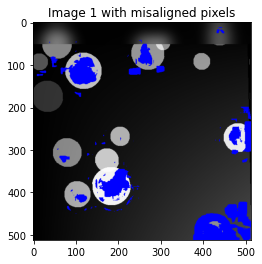

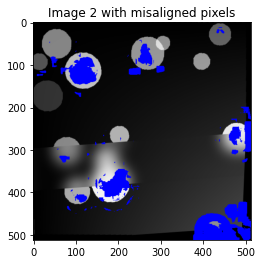

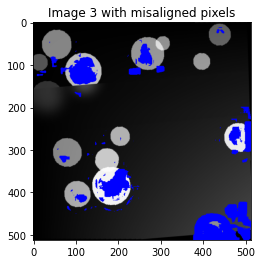

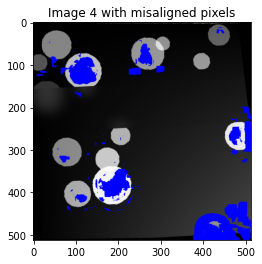

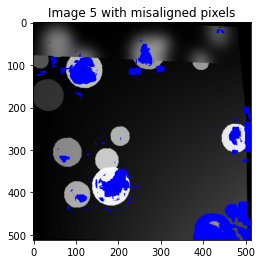

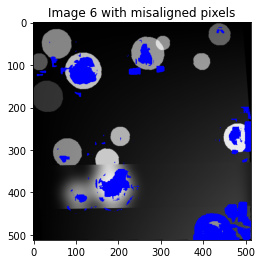

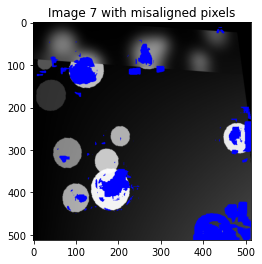

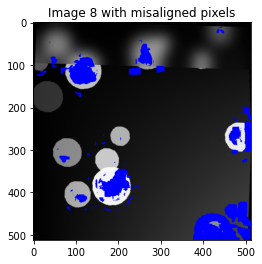

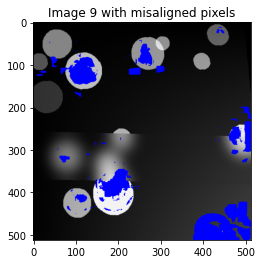

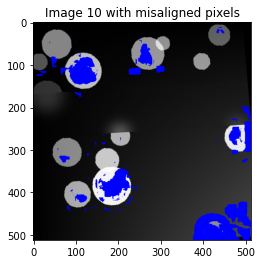

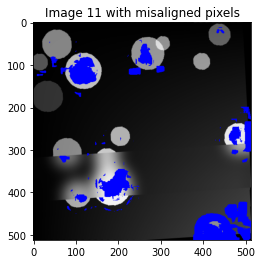

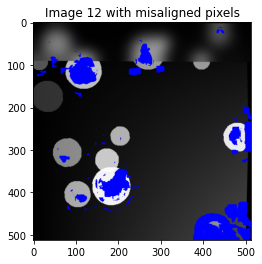

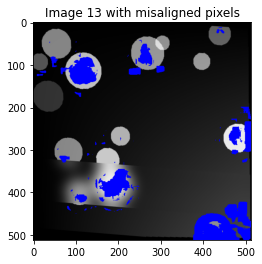

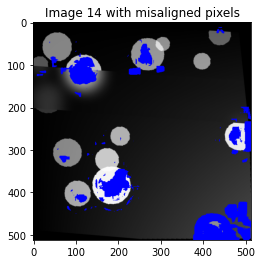

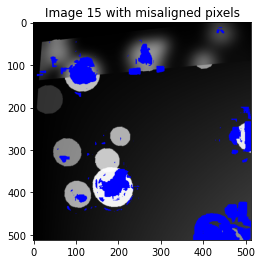

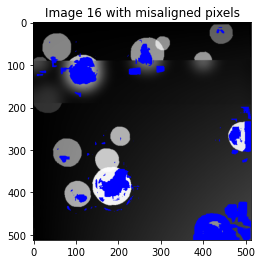

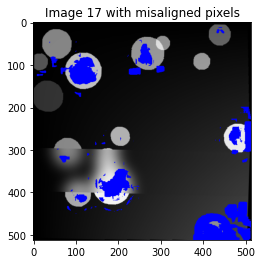

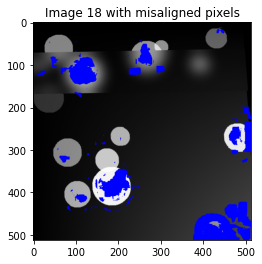

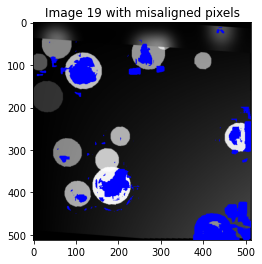

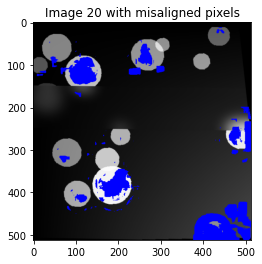

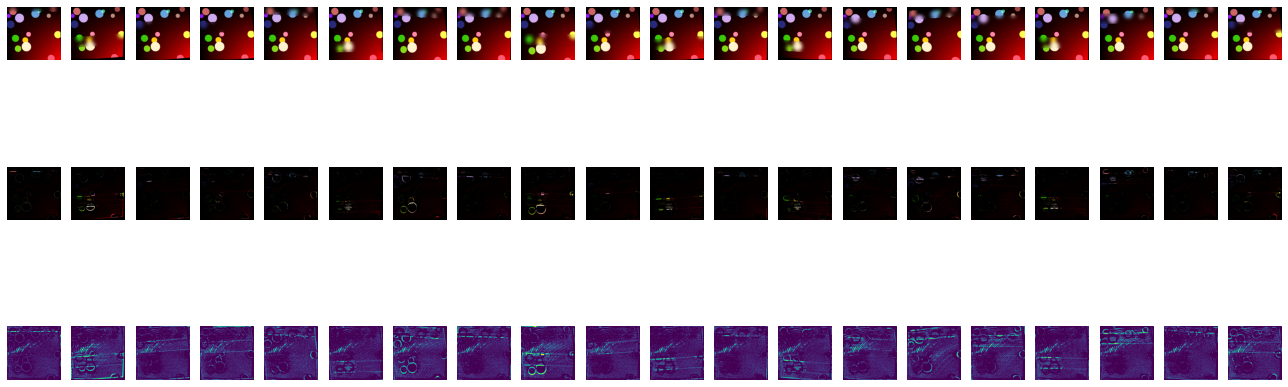

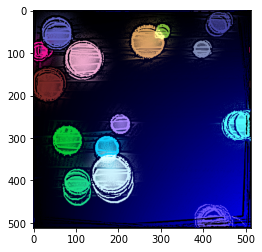

In [4]:
# make output folder if it doesn't exist
preprocessing_time = 0
tic = time.time()
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

number_of_images = count_files_in_folder(folder_counter)
print(f'There are {number_of_images} files in the folder.')

if use_aligned:
    data_dir = f'input/{input_to_use}/aligned/'
else:
    data_dir = f'input/{input_to_use}'

if not os.path.exists(data_dir):
    os.makedirs(data_dir)

if align_images_flag:
    images = load_images(folder_counter)
    aligned_images = align_images(images)
    # print the shape of the dataset
    # save aligned images in data_dir folder
    for i in range(len(aligned_images)):
        # fix color
        aligned_images[i] = cv2.cvtColor(aligned_images[i], cv2.COLOR_BGR2RGB)
        cv2.imwrite(data_dir + "aligned" + str(i) + ".png", aligned_images[i])
if get_masks_flag:
    # get masks
    masks, baseline_result = doLapStack(read_images(data_dir))
print("masks shape and type: ", masks.shape, type(masks))
detect_misaligned_pixels(read_images(data_dir), threshold=30.0)


custom_dataset = CustomImageDataset(data_dir, masks)
batch_size = number_of_images
dataloader = data.DataLoader(custom_dataset, batch_size=batch_size, shuffle=False)
toc = time.time()
preprocessing_time += toc-tic
# display a single batch of images
# get some random training images
dataiter = iter(dataloader)
images, gt, masks = dataiter.next()


# Convert the tensors to numpy arrays
images = images.numpy()
masks = masks.numpy()

# Plot the images and masks
fig, axes = plt.subplots(nrows=3, ncols=batch_size, figsize=(18,8))

for i in range(batch_size):
    # Plot the image
    axes[0][i].imshow(np.transpose(gt[i], (1, 2, 0)))
    axes[0][i].axis('off')
    # include only 1 values from the mask in the image
    gt_masked = gt[i] * masks[i]
    new_mask = gt_masked != 0
    axes[1][i].imshow(np.transpose(gt_masked, (1, 2, 0)))
    axes[1][i].axis('off')
    
    # Plot the mask in grey scale
    axes[2][i].imshow(np.transpose(masks[i], (1, 2, 0)))
    axes[2][i].axis('off')

plt.tight_layout()
plt.show()

# show baseline result
plt.imshow(baseline_result)
plt.show()

# save baseline result
save_as_image(baseline_result, output_folder, "baseline_result.png")

### Here is the definition of our dynamic multiautoencoder

In [5]:
class MultiAutoencoder(nn.Module):
    def __init__(self):
        super(MultiAutoencoder, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.decoder = nn.Sequential(
            nn.Conv2d(64*number_of_images, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 3, kernel_size=3, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = []
        for i in range(number_of_images):
            encoded.append(self.encoder(x[i].unsqueeze(0)))
        x = torch.cat(encoded, dim=1)
        # x = self.encoder(x)
        x = self.decoder(x)
        return x

### The following is used to calculate the sharpness of the image

In [6]:
# test new laplacian filter
# Define the Laplacian filter
laplacian_kernel = torch.tensor([[0, 1, 0], [1, -4, 1], [0, 1, 0]], dtype=torch.float32)
laplacian_kernel = torch.stack([laplacian_kernel] * 3, dim=0).unsqueeze(0)
if torch.cuda.is_available():
    laplacian_kernel = laplacian_kernel.cuda()

# Define the loss function
def sharpness_loss(output):
    laplacian_output = F.conv2d(output, laplacian_kernel, padding=1)
    return -laplacian_output.abs().mean()

### The following is a training loop

In [7]:
## here we are using masks for the loss calculation

# Define the autoencoder model normal loss function
model = None
model = MultiAutoencoder()
model.to(device)
model.train()
# gtt = gtt.to(device)
sharpness_criterion = nn.L1Loss()
criterion = nn.MSELoss()
lr = 0.0005
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
# Create a learning rate scheduler that decays the learning rate by a factor of 0.1 every 30 epochs
# scheduler = StepLR(optimizer, step_size=10, gamma=0.1)

# train autoencoder on masked images


def mse_average(output, imgs, masks):
    for i in range(len(imgs)):
        masked_prediction = output.squeeze(0) * masks[i]
        new_mask = masked_prediction != 0
        # print("shapes: ", output.shape, imgs[i].shape, mask[i].shape)
        if i == 0:
            mse = criterion(output.squeeze(0) * mask[i], imgs[i] * mask[i])
        else:
            mse += criterion(output.squeeze(0) * mask[i], imgs[i] * mask[i])
    return mse / len(imgs)

num_epochs = 300
alpha = 0.005
beta = 1.0-alpha
results = []

training_time = 0
tic = time.time()
for epoch in range(num_epochs):
    for data in dataloader:
        img, gt, mask = data
        img = img.to(device)
        mask = mask.to(device)
        gt = gt.to(device)
        # Forward pass
        output = model(img)
        f_loss = sharpness_loss(output)
        s_loss = mse_average(output, gt, mask)
        ## if you want to include weighted sharpness loss
        # loss = alpha * f_loss + beta * s_loss
        loss = s_loss
            
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    # scheduler.step()
    # Print the loss for this epoch
    
    if sharpness:
        extra_text = "Epoch [{}/{}], loss={:.4f}. Sharpness Loss: {:.4f}. Similarity Loss: {:.4f}".format(epoch+1, num_epochs, loss.item(), f_loss.item(), s_loss.item() )
        results.append((epoch, output, loss, f_loss, s_loss, [alpha, beta]))
    else:
        extra_text = "Epoch [{}/{}], loss={:.4f}".format(epoch+1, num_epochs, loss.item())
        results.append((epoch, output, loss, [alpha, beta]))
    progress_bar(epoch, num_epochs, extra_text)
toc = time.time()
training_time += toc - tic

# save the model
torch.save(model.state_dict(), f"models/{experiment_name}.pth")
# torch.save(best_model.state_dict(), f"models/best_{experiment_name}.pth")

### Plot and visualize the results

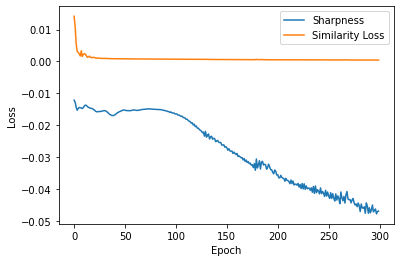

FAIS sharpness:  -0.04816204309463501
gtt sharpness:  -0.2694163918495178


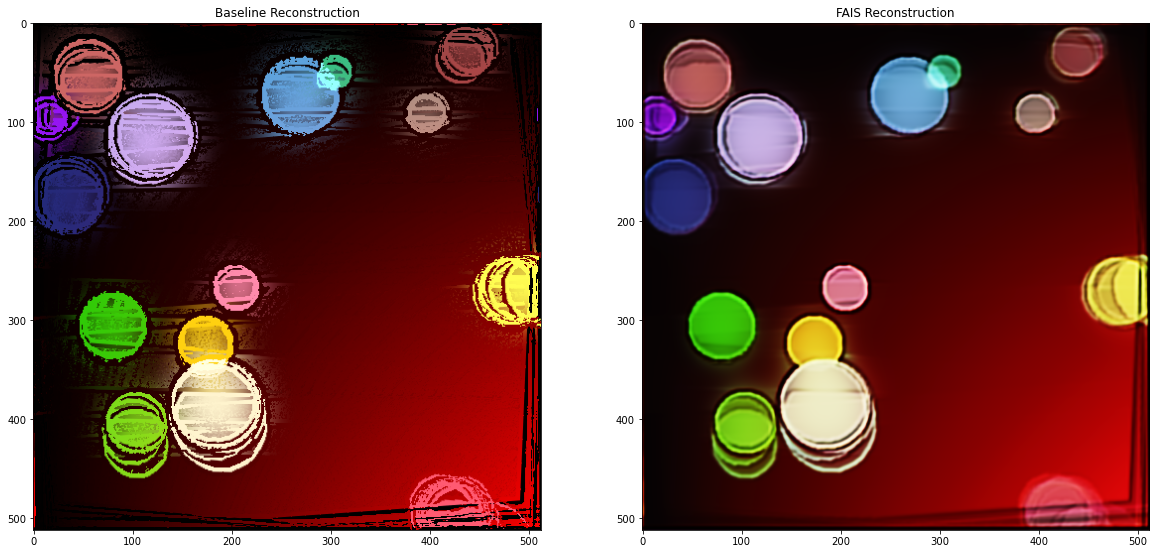

In [8]:
plot_loss(results, experiment_name, sharpness)

output_file = f'output/{input_to_use}/baseline_result.png'
gtt = Image.open(output_file).convert('RGB')
# get gtt size H and W
gtt_size = gtt.size

transform = transforms.Compose([
            transforms.Resize((int(gtt_size[1]), int(gtt_size[0]))),
            transforms.ToTensor(),
            # transforms.Normalize(mean, std)
        ])


gtt = transform(gtt)
# save gtt image to output folder
torchvision.utils.save_image(gtt, f'output/{input_to_use}/resize_beseline_result.png')

# visualize the output
import matplotlib.pyplot as plt
import torchvision
%matplotlib inline

use_old_model = None
use_best_model = True


# if model_to_use == "MultiAutoencoder":
#     model = MultiAutoencoder()

# # load model from model.pth
# if use_old_model is not None:
#     model = Autoencoder().to(device)
#     model.load_state_dict(torch.load(f'{use_old_model}.pth'))
# elif use_best_model:
#     # model = Autoencoder().to(device)
#     model.load_state_dict(torch.load(f'models/best_{experiment_name}.pt'))
    
# move model to device
model.to(device)
# obtain one batch of test images
dataiter = iter(dataloader)
images, gt, masks = dataiter.next()

# get sample outputs
images = images.to(device)
model.eval()
output = model(images)
FAIS_sharpness = sharpness_loss(output).item()
print("FAIS sharpness: ", FAIS_sharpness)

# prep images for display
images = images.cpu().detach() # convert images to numpy for display
output = output.cpu().detach() # convert images to numpy for display
# save output of the model to a file
torchvision.utils.save_image(output, f'output/{input_to_use}/FAIS_result.png')

# Reverse the normalization step for each image in the batch
for i in range(images.shape[0]):
    images[i] = (images[i] * torch.tensor(std).view(3, 1, 1)) + torch.tensor(mean).view(3, 1, 1)

# for i in range(output.shape[0]):
#     output[i] = (output[i] * torch.tensor(std).view(3, 1, 1)) + torch.tensor(mean).view(3, 1, 1)

# Reverse the normalization step for gt image
# gtt = (gtt * torch.tensor(std).view(3, 1, 1)) + torch.tensor(mean).view(3, 1, 1)

# plot one image from the batch and the recunsructed image
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,10))

# original image
# switch red and blue channels in gtt imag
# calculate gtt sharpness
gtt_sharpness = sharpness_loss(gtt.unsqueeze(0).to(device)).item()
print("gtt sharpness: ", gtt_sharpness)
axes[0].imshow(np.transpose(gtt, (1, 2, 0)))
axes[0].set_title('Baseline Reconstruction')

# reconstructed image
axes[1].imshow(np.transpose(output[0], (1, 2, 0)))
axes[1].set_title('FAIS Reconstruction')

# save images to results folder
plt.savefig(f'output/{input_to_use}/{num_epochs}itr.png')

if make_gif:
    import imageio
    images = []
    for e in range(num_epochs):
        progress_bar(e, num_epochs, 'generating gif')
        img = np.transpose(results[e][1][0].cpu().detach().numpy(), (1, 2, 0))
        # concatenate the original and reconstructed images
        # img = np.concatenate((img, np.transpose(results[e][2][0].cpu().detach().numpy(), (1, 2, 0))), axis=1)
        # convert to uint8
        img = (img * 255).astype(np.uint8)
        images.append(img)
    progress_bar(e, num_epochs, 'saving gif...')
    imageio.mimsave(f'output/{input_to_use}/_{num_epochs}itr.gif', images)
    print('Done!')

# save time and sharpness to txt file
with open(f'output/{input_to_use}/time.txt', 'w') as f:
    f.write(f'training time: {training_time}\n')
    f.write(f'preproccessing time: {preprocessing_time}')
with open(f'output/{input_to_use}/sharpness.txt', 'w') as f:
    f.write(f'FAIS sharpness: {FAIS_sharpness}\n')
    f.write(f'baseline sharpness: {gtt_sharpness}')
